# 2.7 Grad-CAM

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_7 import MNIST_CNN
from utils import find_roi

%matplotlib inline

mnist_cluttered = np.load('./MNIST_cluttered/mnist_sequence1_sample_5distortions5x5.npz')
X_train = mnist_cluttered['X_train']
y_train = mnist_cluttered['y_train']
X_valid = mnist_cluttered['X_valid']
y_valid = mnist_cluttered['y_valid']
X_test = mnist_cluttered['X_test']
y_test = mnist_cluttered['y_test']

logdir = './tf_logs/2_7_GCAM/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 1600], name='X')
    Y = tf.placeholder(tf.int64, [None], name='Y')
    Y_hot = tf.one_hot(Y, 10)

    activations, logits = DNN(X)
    
    tf.add_to_collection('GCAM', X)
    tf.add_to_collection('GCAM', logits)
    
    for activation in activations:
        tf.add_to_collection('GCAM', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_hot))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 20
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(np.shape(X_train)[0] / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = X_train[i * batch_size:(i+1) * batch_size], y_train[i * batch_size:(i+1) * batch_size].reshape([-1])
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: X_test, Y: y_test.reshape([-1])}))

sess.close()

Epoch: 0001 cost = 1.030643322 accuracy = 0.651499999
Epoch: 0002 cost = 0.311122569 accuracy = 0.899800000
Epoch: 0003 cost = 0.165329344 accuracy = 0.947400004
Epoch: 0004 cost = 0.099200475 accuracy = 0.969800007
Epoch: 0005 cost = 0.063634451 accuracy = 0.980600010
Epoch: 0006 cost = 0.042079523 accuracy = 0.987400008
Epoch: 0007 cost = 0.040920208 accuracy = 0.987100008
Epoch: 0008 cost = 0.020570403 accuracy = 0.993800006
Epoch: 0009 cost = 0.012259435 accuracy = 0.996100004
Epoch: 0010 cost = 0.003470667 accuracy = 0.999200001
Epoch: 0011 cost = 0.002051868 accuracy = 0.999800000
Epoch: 0012 cost = 0.000328182 accuracy = 1.000000000
Epoch: 0013 cost = 0.000159415 accuracy = 1.000000000
Epoch: 0014 cost = 0.000116227 accuracy = 1.000000000
Epoch: 0015 cost = 0.000092466 accuracy = 1.000000000
Epoch: 0016 cost = 0.000076532 accuracy = 1.000000000
Epoch: 0017 cost = 0.000064278 accuracy = 1.000000000
Epoch: 0018 cost = 0.000054975 accuracy = 1.000000000
Epoch: 0019 cost = 0.0000474

### 4. Restoring Subgraph

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

activations = tf.get_collection('GCAM')
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')

X = activations[0]
logits = activations[1]
activations = activations[2:]

sample_imgs = [X_train[y_train.reshape([-1]) == i][5] for i in range(10)]

INFO:tensorflow:Restoring parameters from ./tf_logs/2_7_GCAM/model


### 5. Generating CAMs

In [5]:
last_conv = activations[5]
gradients = [tf.gradients(logits[:,i,None], last_conv)[0] for i in range(10)]
partial_lin = [tf.nn.avg_pool(gradient, [1, 10, 10, 1], [1, 1, 1, 1], 'VALID') for gradient in gradients]
grad_cams = [tf.nn.relu(tf.reduce_sum(last_conv * partial_lin[i], axis=3, keep_dims=True)) for i in range(10)]
resized_grad_cams = [tf.image.resize_bilinear(grad_cams[i], [40,40], align_corners=True) for i in range(10)]

hmaps = np.reshape([sess.run(resized_grad_cams[i], feed_dict={X: sample_imgs[i][None]}) for i in range(10)], [10, 40, 40])

### 6. Displaying Images

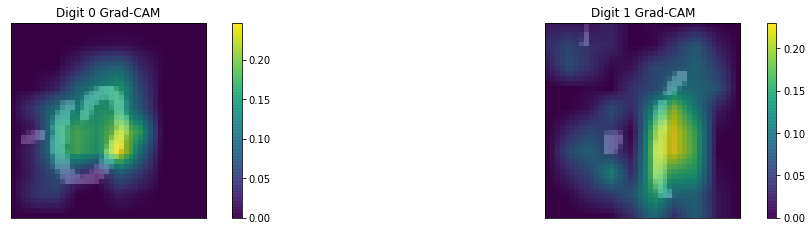

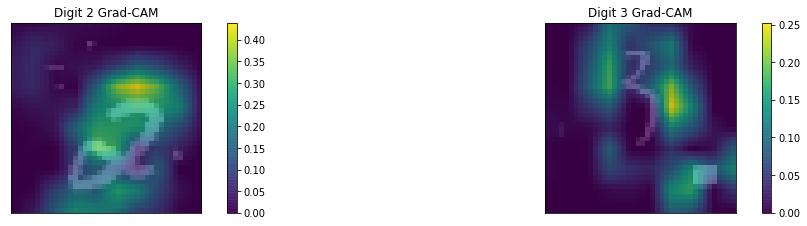

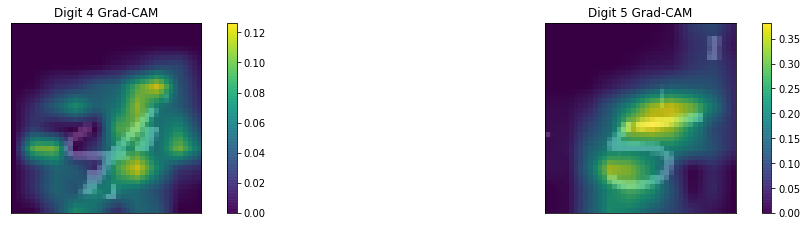

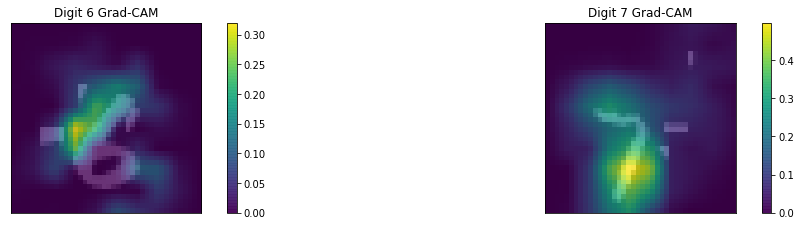

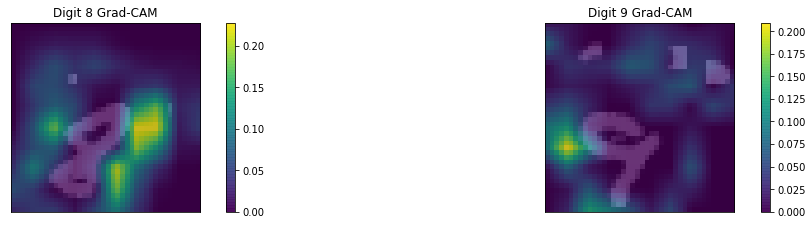

In [6]:
for i in range(5):
    plt.figure(figsize=(15,15))
    for j in range(2):
        plt.subplot(5, 2, i * 2 + j + 1)
        plt.imshow(sample_imgs[i * 2 + j].reshape(40,40), cmap='gray')
        plt.imshow(hmaps[i * 2 + j], alpha=0.8)
        plt.title('Digit {} Grad-CAM'.format(i * 2 + j))
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()